In [2]:
import os.path as op
import sys
sys.path.append(op.abspath('../../'))

sys.path.append(op.abspath('../../../../'))

from os import environ
environ["ANAROOT"] = op.abspath('../../../../')

# Clustering with few variables

The purpose of this notebook is to perform clustering using only a few variables (instead of the brute-force approach of feeding the clustering algorithm with the 32 samples). In the notebook `look_for_other_columns.ipynb`, we have come up with two new features `mean_before_end_peak` and `mean_after_end_peak`, that seem to be discriminative enough.

## Libraries

In [3]:
import numpy as np
import models
import var, fcts

from project import files, defs, col
from lib import data, plot as lp, clustering


## Simulation

### Parameters

In [4]:
N = 100000
S = 100000
P = 100000


shift_pedestal = (600, 150)
amp_S = 30  # (25, 5)
std_N = 1.

# Peaked
n_peaks = (1, 6)  # between 1 and 6 peaks / event
amp_P = (1, 30)  # peak amplitude between 1 and 15
length_peaks = (1, 3)  # length of a peak between 1 and 3

shift_pedestal = (600, 150)

optimised = False

components = {
    "S": {"S": S, "amp_S": amp_S, "true_pedestal": True},
    "N": {"N": N, "std_N": std_N, "true_pedestal": True},
    "P": {
        "P": P, "n_peaks": n_peaks,
        "amp_P": amp_P, "length_peaks": length_peaks
    }
}

bdt_name = "BDT_SNP"

image_path = op.join(var.image_path, bdt_name)


### Simulation

In [6]:
rng = np.random.default_rng(12345)

dataframe = models.get_full_dataframe(
    components,
    shift_pedestal=shift_pedestal,
    random_time_shift=True,
    rng=rng
)

dataframe[defs.list_samples_columns] += np.random.uniform(
    low=-0.5, high=0.5, size=(len(dataframe), len(defs.list_samples_columns))
)

dataframe = files.compute_voi(
    dataframe,
    variables=defs.computed_variables +
    ['std_pos', 'std_neg']
)




Time taken: 1.1808795928955078


In [7]:
dataframe['mid'] = (dataframe['max'] + dataframe['min']) / 2

In [8]:
columns_already_computed = [
    'pos_max', 'pos_min',
    'std',
    'std_pos', 'std_neg',
]

columns_to_compute = [
    'max_m_mean',
    'mean_m_pedestal',
    'min_m_pedestal',
    'max_m_pedestal',
    'min_std_pos_neg',
    'max_std_pos_neg',
    'min_std_pos_neg_red',
    'max_std_pos_neg_red',
    'max_m_mean',
    'max_m_mean_red',
    'min_m_mean', 'min_m_mean_red',
    'median_m_mean', 'median_m_mean_red',
    'mid_m_mean', 'mid_m_mean_red'
]

new_columns = ['mean_before_end_peak', 'mean_after_end_peak', 'pos_first_neg_after_max']
columns_to_compute += ['mean_before_end_peak_red', 'mean_after_end_peak_red']

In [9]:
files.compute_peak_voi(dataframe, zero_column="mean", red=True) 
files.compute_threshold_voi(dataframe, ref_column="min", threshold=0.8) 

# Get the formula of the columns to compute
formula_columns = col.get_formula_columns(columns_to_compute)
formula_column_labels = col.get_formula_labels(
    columns_to_compute, defs.column_labels
)
column_labels = {**defs.column_labels, **formula_column_labels}

# Compute them
dataframe = data.compute_vals(dataframe, formula_columns)

Time taken: 0.3049290180206299
Time taken: 0.30440235137939453


### Checking plots

In [10]:
dict_df = models.get_dict_df(dataframe)
list_compos = ['S', 'N', 'P']
list_df = [dict_df[compo] for compo in list_compos]
list_colors, list_labels = fcts.get_list_colors_labels(list_compos)

In [11]:
# fig, axes = lp.multi_plot_hist(
#     list_df, 
#     new_columns, column_labels,
#     list_colors=list_colors,
#     list_labels=list_labels,
#     logscale=True,
#     nbins={
#         'default': 20,
#         'pos_first_neg_after_max': 32
#     },
#     range_columns={
#         'default': 20,
#         'pos_first_neg_after_max': [0, 31]
#     }
# )

# lp.save_fig(fig, image_path, "compare_SNP")


In [12]:
dataframe = dataframe.query("pos_first_neg_after_max!=-1")


In [13]:
dataframe_no_peaked = dataframe.query('is_peaked==False')


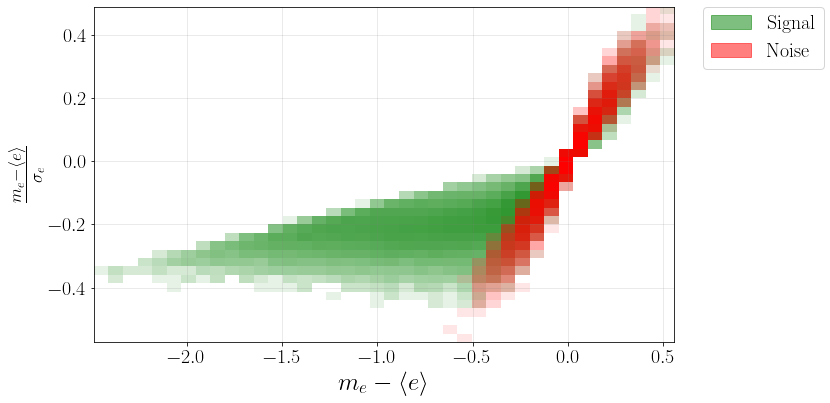

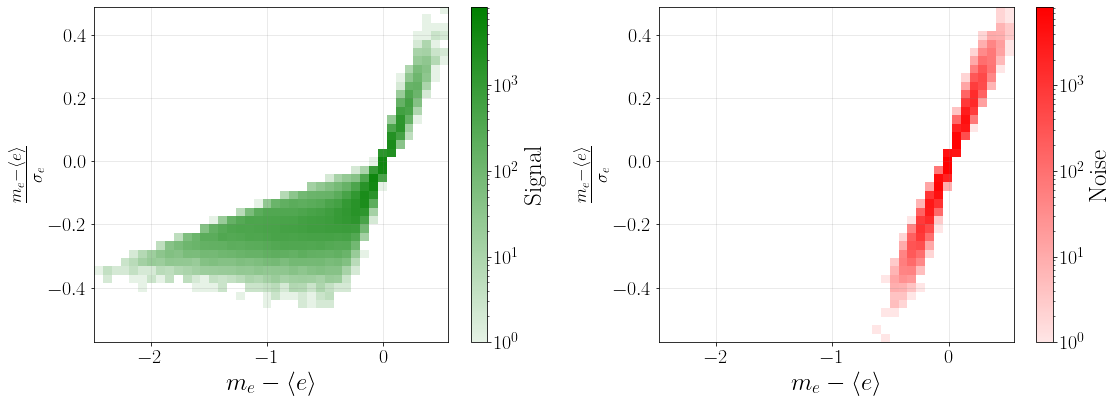

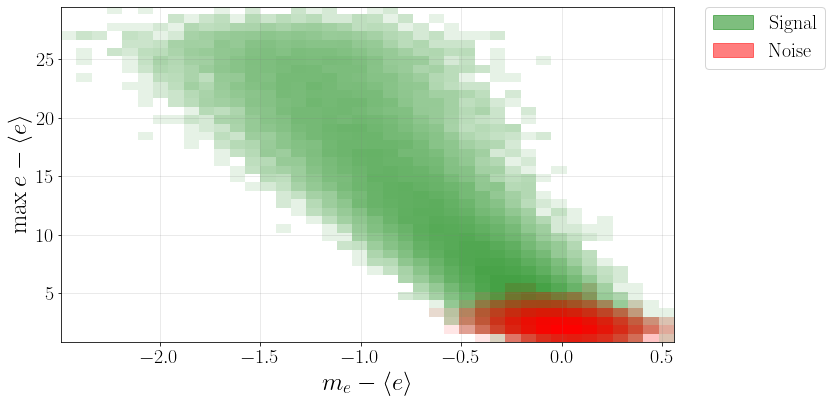

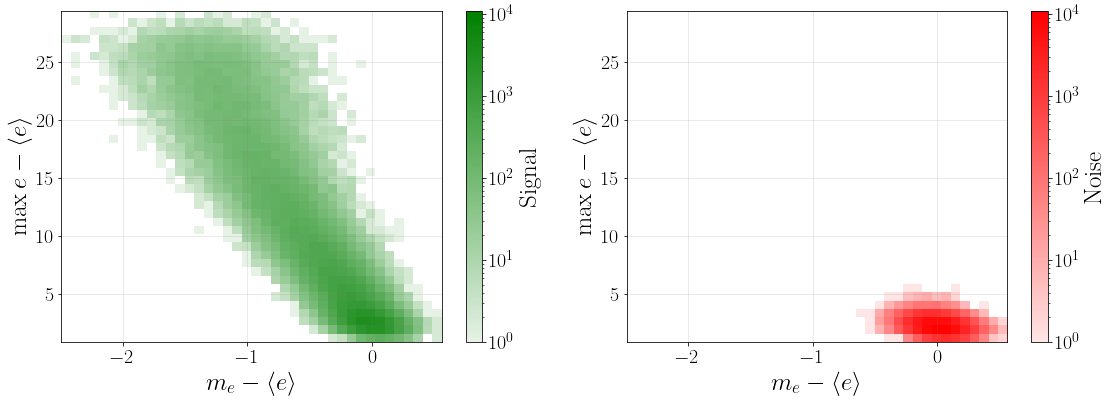

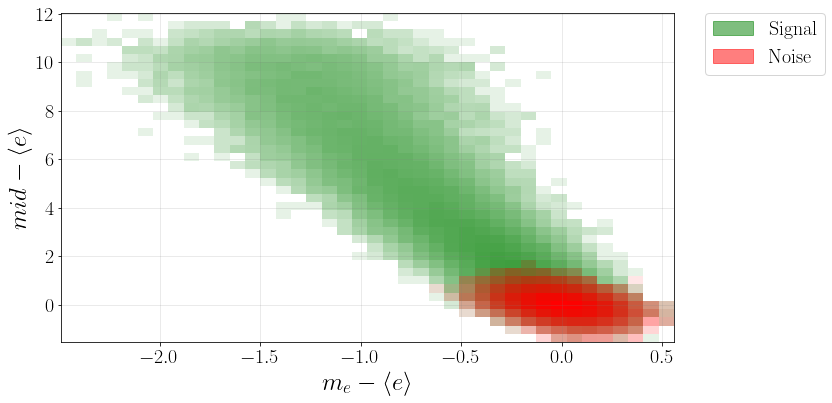

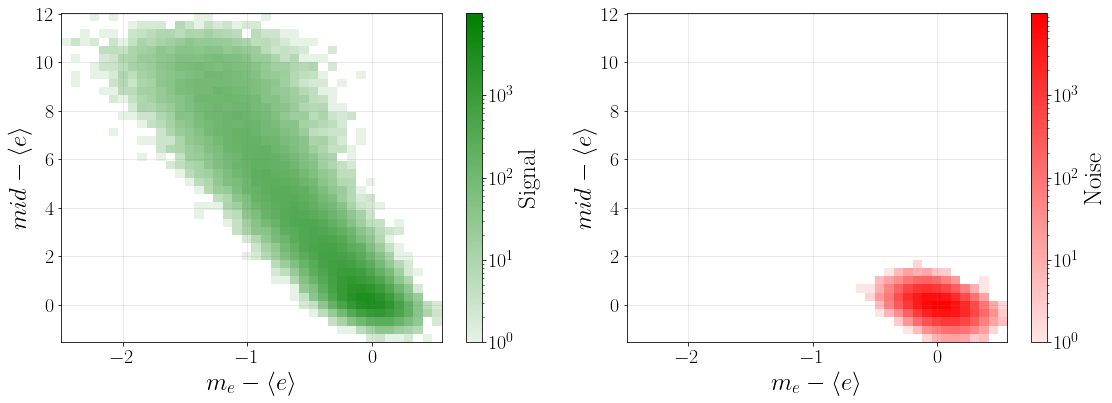

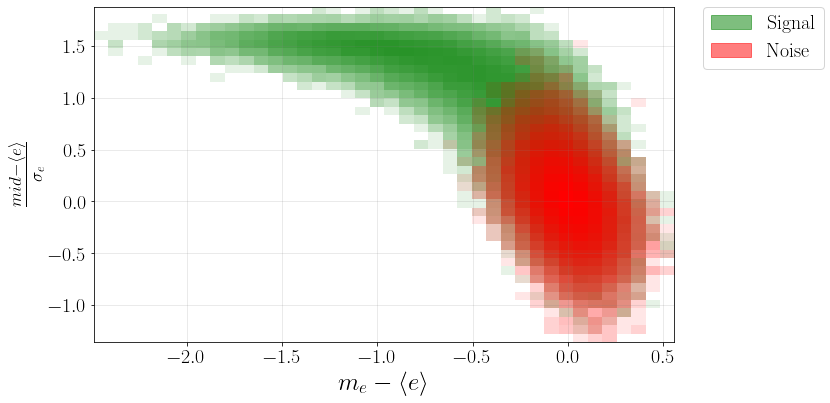

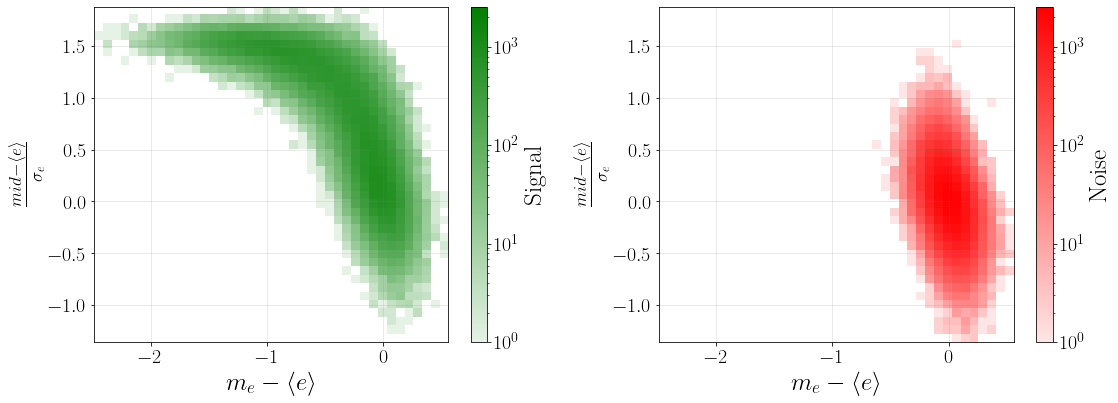

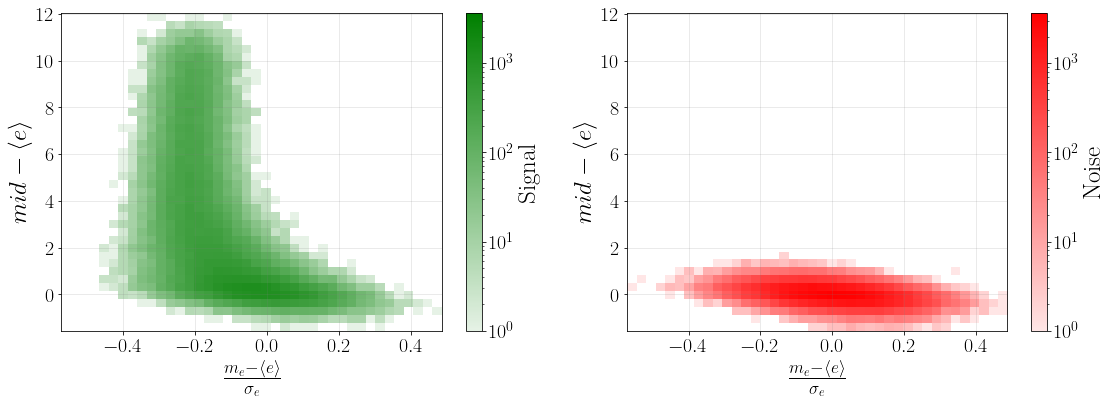

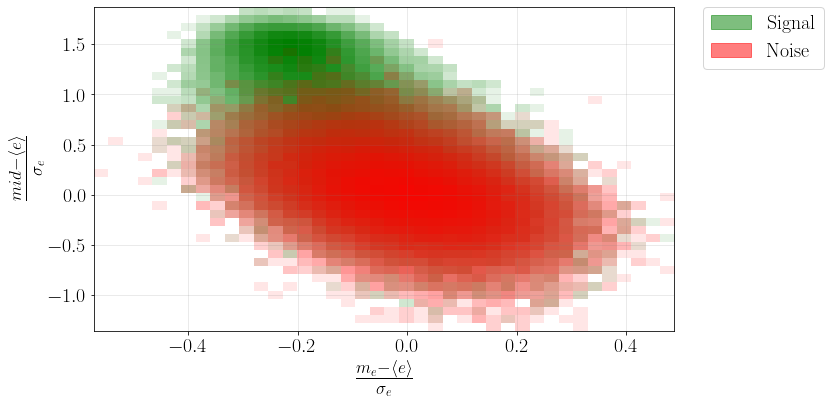

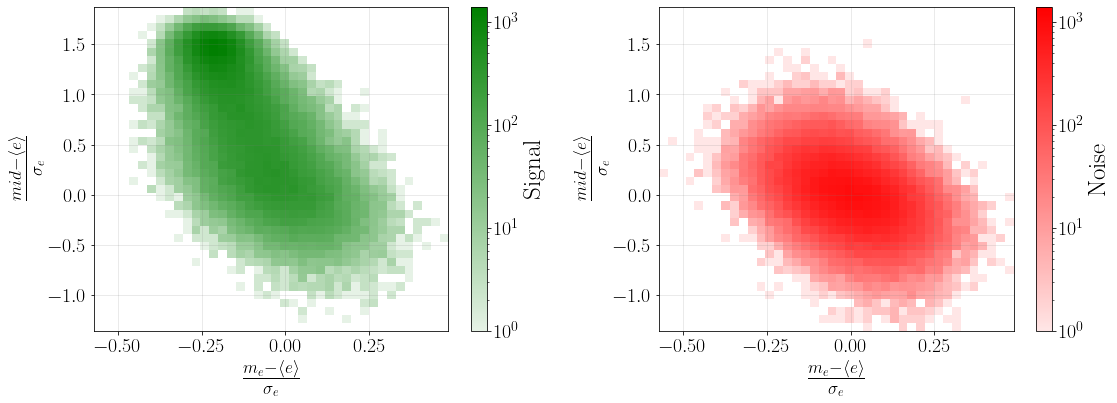

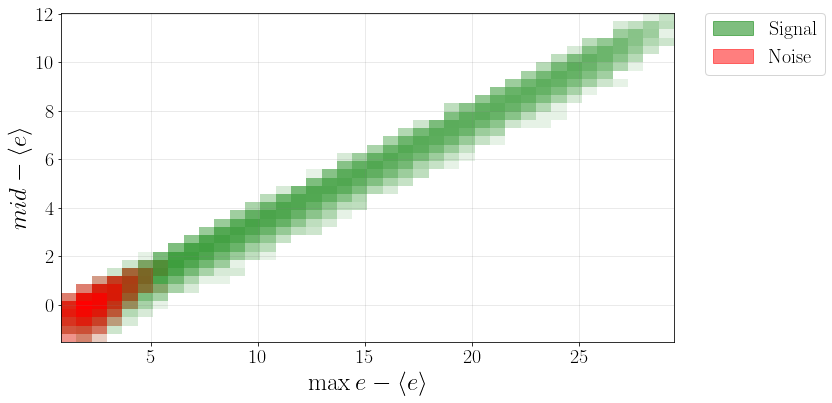

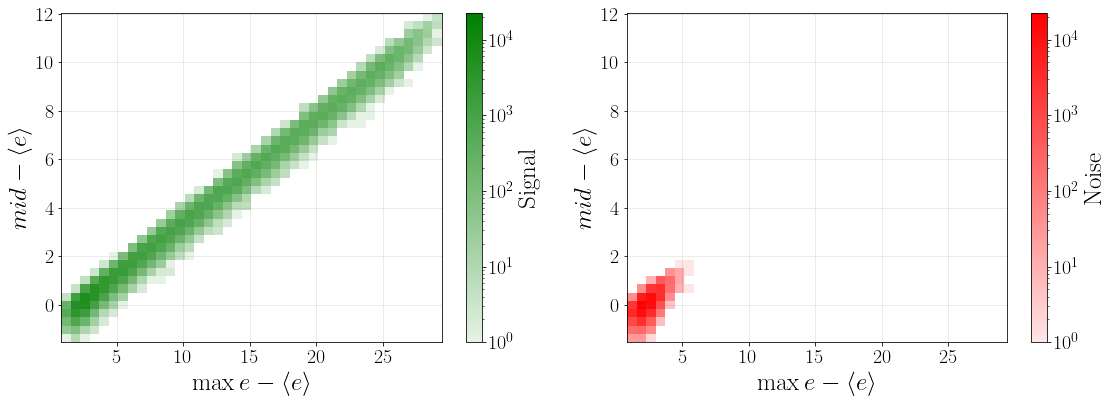

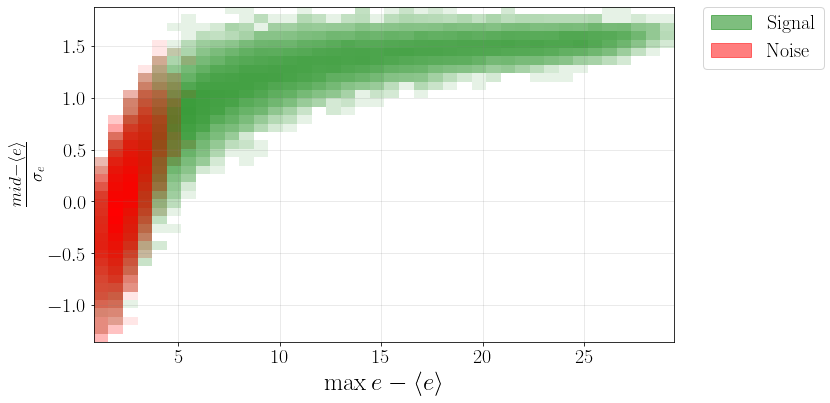

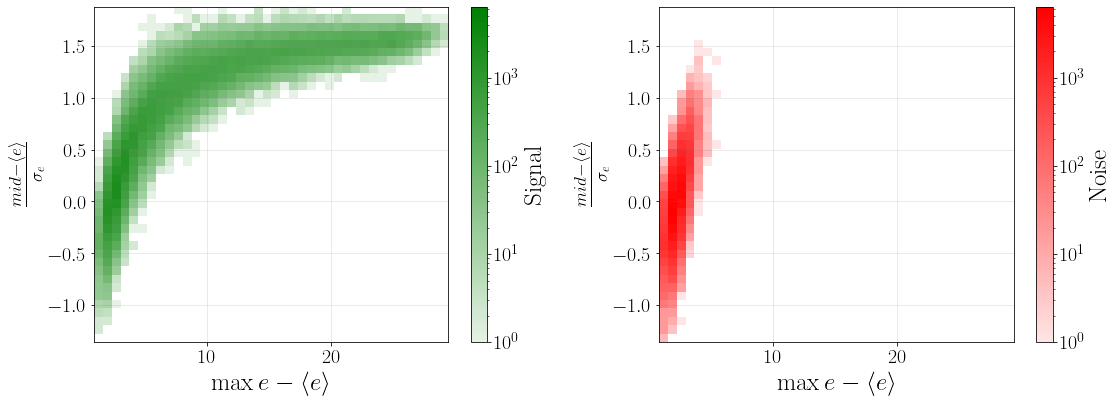

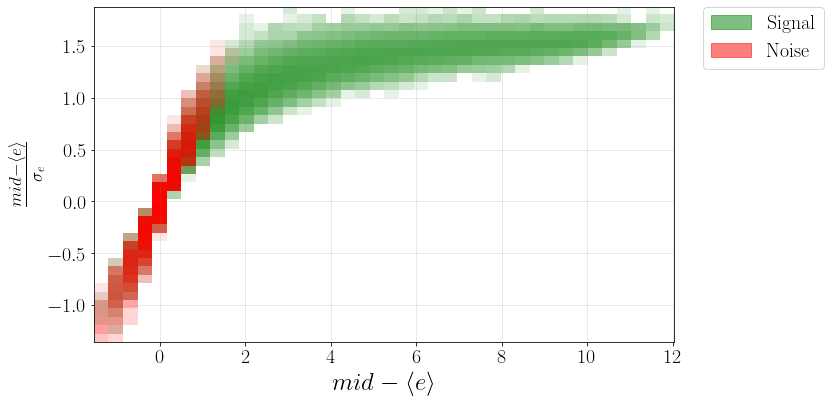

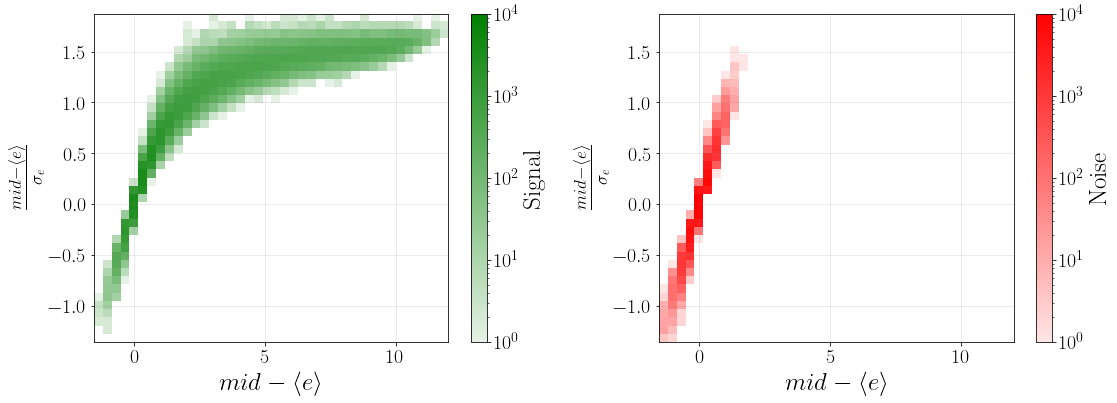

In [14]:
# name_var1 = "mean_before_end_peak"
# name_var2 = "mean_after_end_peak"

features = ["mean_before_end_peak", "mean_after_end_peak", "max_m_mean"]
interesting_features = [
    # "mean_before_end_peak", "mean_after_end_peak", "pos_max", 
    # "mean_m_pedestal", 
    # "max_m_mean_red", "min_m_mean_red",
    "median_m_mean", "median_m_mean_red",
    "max_m_mean", 'mid_m_mean', 'mid_m_mean_red'
]
list_compos_no_peaked = ['S', 'N']

import itertools

column_ranges = {
    "pos_max": [0, 31]
}
column_nbins = {
    "pos_max": 32,
    "default": 40
}

for name_var1, name_var2 in itertools.combinations(interesting_features, 2):
    min_max = [None, None]
    bins = [None, None]

    if name_var1 in column_ranges:
        min_max[0] = column_ranges[name_var1]
    if name_var2 in column_ranges:
        min_max[1] = column_ranges[name_var2]

    bins[0] = column_nbins.get(name_var1, column_nbins['default'])
    bins[1] = column_nbins.get(name_var2, column_nbins['default'])

    if bins==[None, None]:
        bins = None
    fcts.multi_plot_hist2d_cats(
        dataframe_no_peaked, 
        name_var1, name_var2,
        column_labels[name_var1], column_labels[name_var2],
        list_compos_no_peaked,
        min_max=min_max,
        bins=bins
    )

## Clustering - Signal vs Noise

In [ ]:
dataframe_no_peak = dataframe.query(f"{var.dict_df_flags['P']} == False")

dataframe_mixed =  dataframe_no_peak.sample(frac=1.)
dataframe_filtered = dataframe_mixed.query("pos_first_neg_after_max!=-1")

len_before, len_after = len(dataframe_mixed), len(dataframe_filtered)
print("Efficiency:", (len_before - len_after) / len_before)

Efficiency: 0.0


### K-means

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
clu_label_name = "kmeans"
clu_label_alias = "k-means"

In [ ]:
features = ["mean_before_end_peak", "mean_after_end_peak", "max_m_mean"]
cats = ["S", "N"]
kmeans = KMeans(
    init="k-means++", #algorithm="elkan",
    n_clusters=2, random_state=rng.integers(2**32)
)
kmeans = kmeans.fit(dataframe_filtered[features])
dataframe_filtered[clu_label_name] = kmeans.labels_


(<Figure size 1728x432 with 3 Axes>,
 array([<AxesSubplot:xlabel='$\\langle e\\rangle_{\\text{start}}$', ylabel='Number of events'>,
        <AxesSubplot:xlabel='$\\langle e\\rangle_{\\text{end}}$', ylabel='Number of events'>,
        <AxesSubplot:xlabel='$\\max{e} - \\langle e \\rangle$', ylabel='Number of events'>],
       dtype=object))

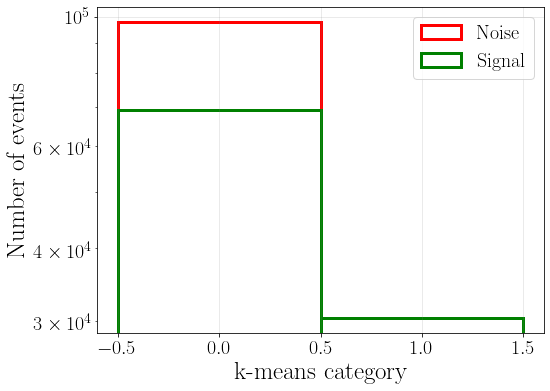

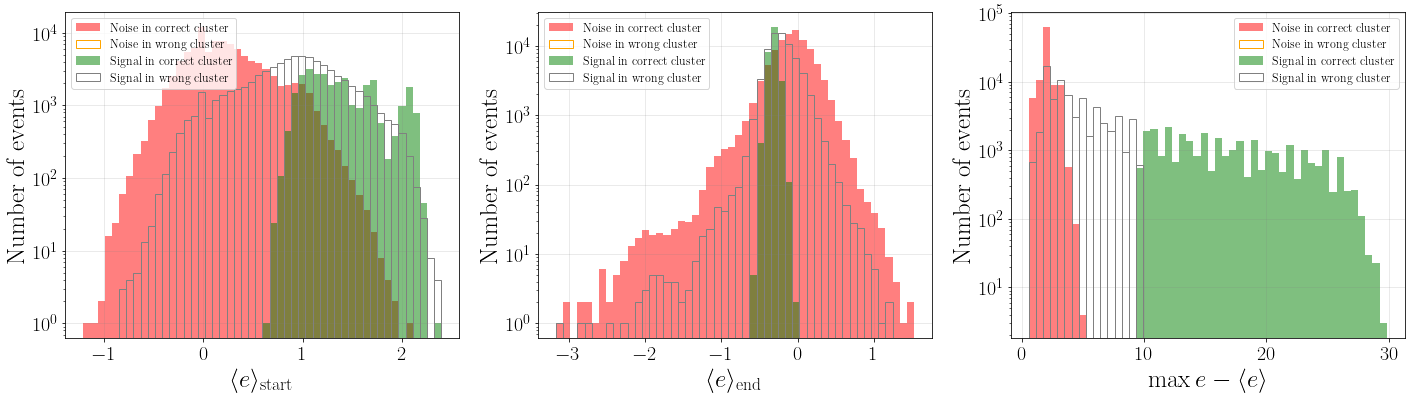

In [ ]:
fcts.plot_result_clustering(
    dataframe_filtered,
    clu_label_name,
    clu_label_alias,
    logscale=True,
    cats=cats[::-1]
)

# Correct cluster labels for each category ---------------------------

correct_clu_label_cats = {
    "S": 1,
    "N": 0,
}

fcts.plot_result_clustering_hist1d(
    dataframe_filtered, features,
    column_labels,
    clu_label_name, correct_clu_label_cats,
    logscale=True,
    cats=cats[::-1]
)

In [ ]:
correct_clu_label_cats = {
    'S': 1,
    'N': 0,
}


fcts.plot_result_clustering_hist2d(
    dataframe_filtered, features,
    column_labels,
    clu_label_name, correct_clu_label_cats,
    logscale=True,
    cats=cats[::-1],
    # dict_color_clu_cats=dict_color_clu_cats
)
import matplotlib.pyplot as plt


No events for Noise in correct cluster
No events for Noise in correct cluster
No events for Noise in correct cluster


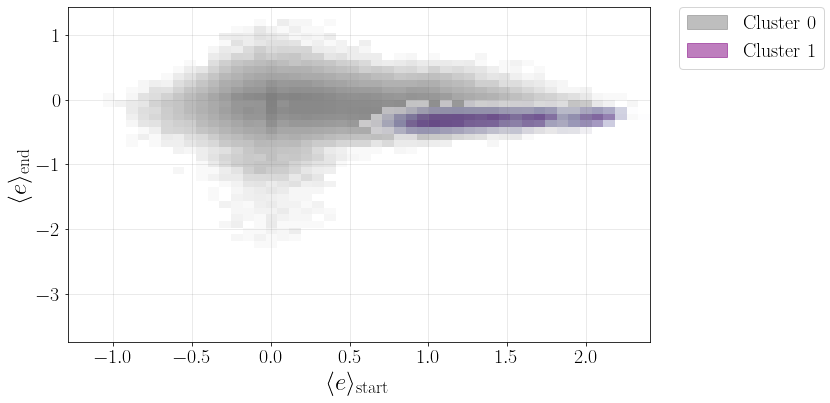

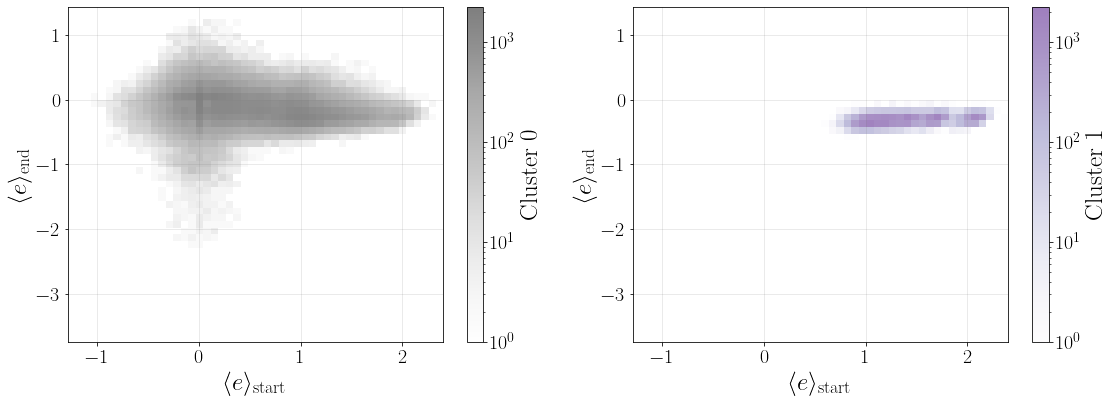

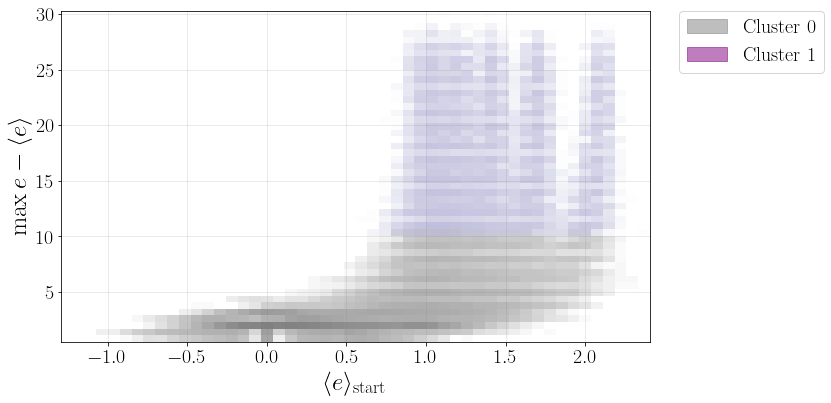

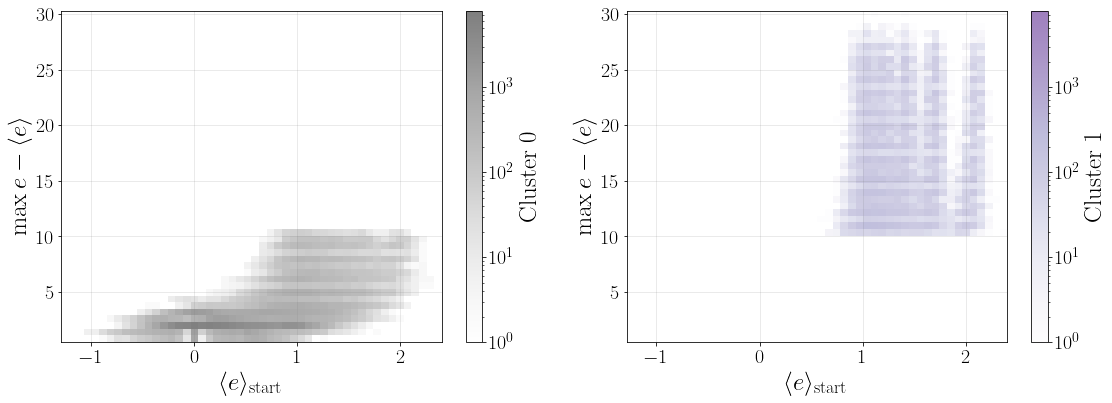

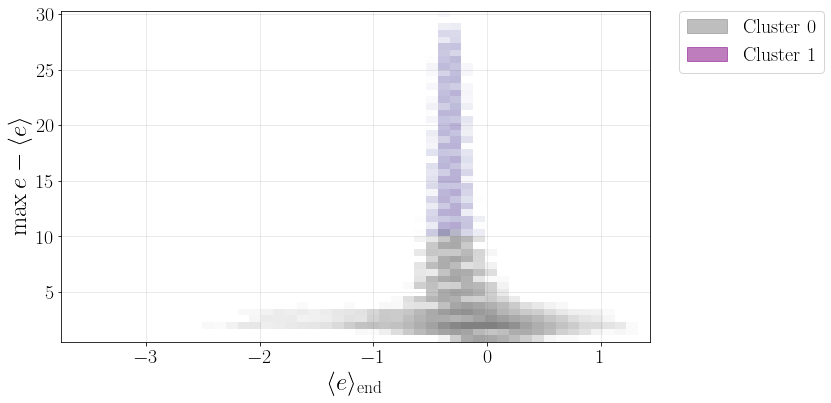

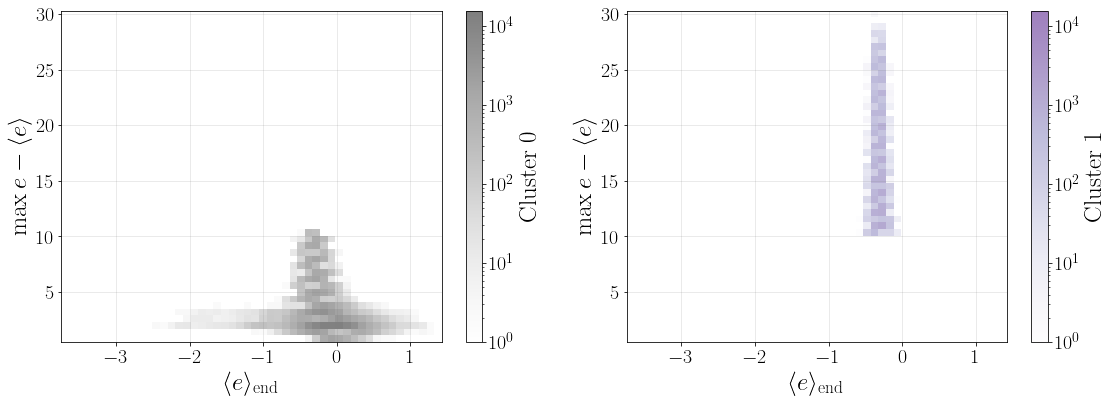

In [ ]:
clustering.plot_clusters_hist2d(
    dataframe_filtered, 
    features,
    column_labels,
    clu_label_name,
    logscale=True
)

(<Figure size 1152x432 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Cluster 0'}, xlabel='Time increment', ylabel='Output'>,
        <AxesSubplot:title={'center':'Cluster 1'}, xlabel='Time increment', ylabel='Output'>],
       dtype=object))

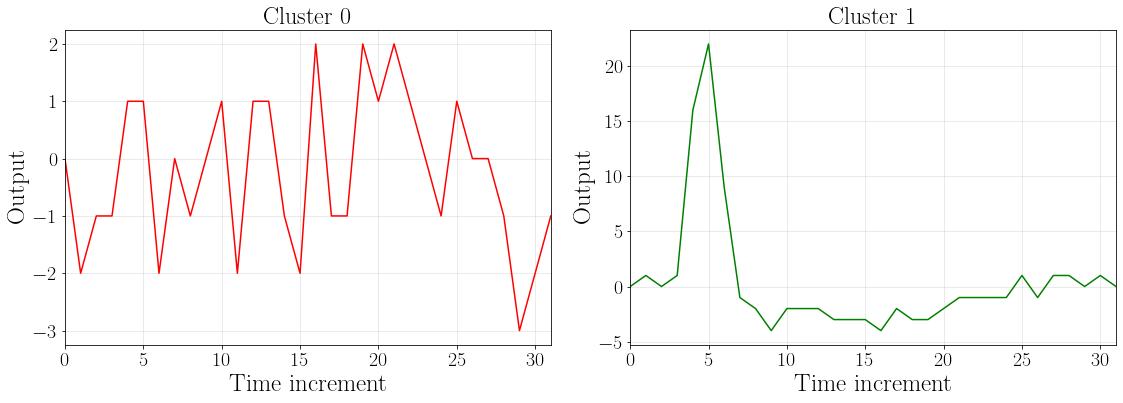

In [ ]:
dict_color_clu_labels = {
    0: 'r',
    1: 'g'
}

clustering.plot_samples_clusters(
    dataframe_filtered,
    clu_label_name,
    dict_color_clu_labels=dict_color_clu_labels
)

### HDBSCAN

In [ ]:
import hdbscan
cats = ['S', 'N']
clu_label_name = "HDBSCAN"
clu_label_alias = "HDBSCAN"

dataframe_filtered = dataframe_filtered.query("is_peaked == False")

In [ ]:
features = [
    "mean_before_end_peak", "mean_after_end_peak", "max_m_mean",
    # "min_std_pos_neg_red"
]


clusterer = hdbscan.HDBSCAN(
    algorithm='best', 
    metric='euclidean',
    min_cluster_size=100,
    min_samples=1,
    cluster_selection_epsilon=.6,
)

clusterer = clusterer.fit(dataframe_filtered[features])
dataframe_filtered[clu_label_name] = clusterer.labels_


In [ ]:
np.unique(dataframe_filtered[clu_label_name])

array([-1,  0,  1])

(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='HDBSCAN category', ylabel='Number of events'>)

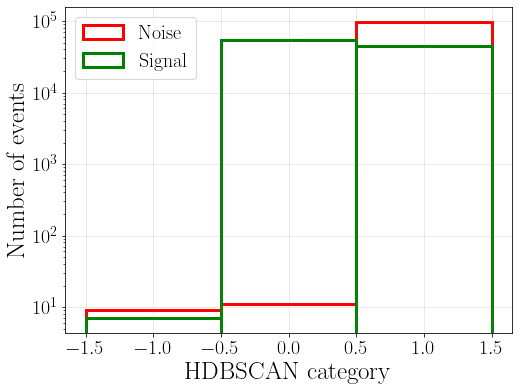

In [ ]:
fcts.plot_result_clustering(
    dataframe_filtered,
    clu_label_name,
    clu_label_alias,
    logscale=True,
    cats=cats[::-1]
)

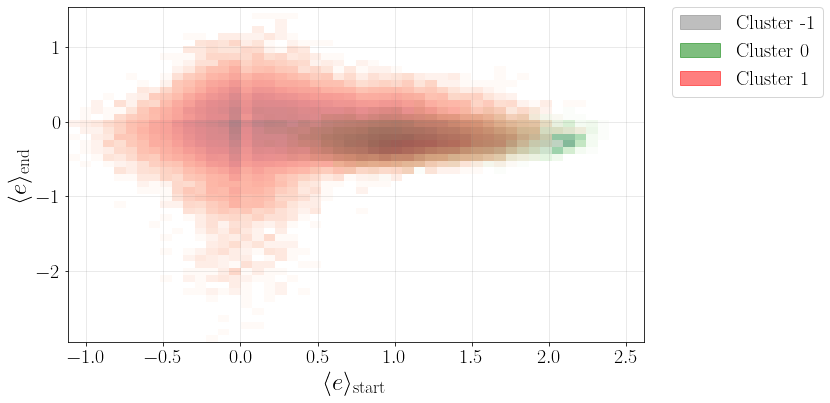

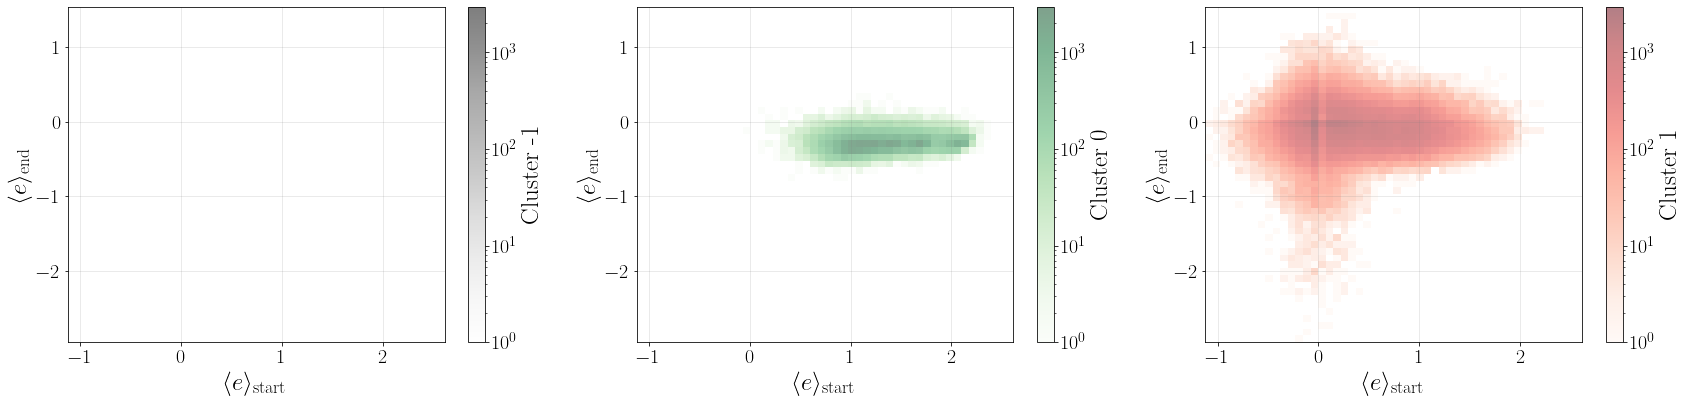

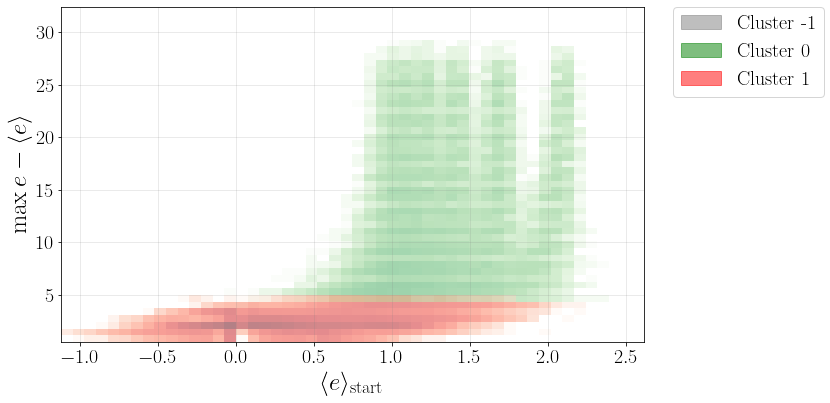

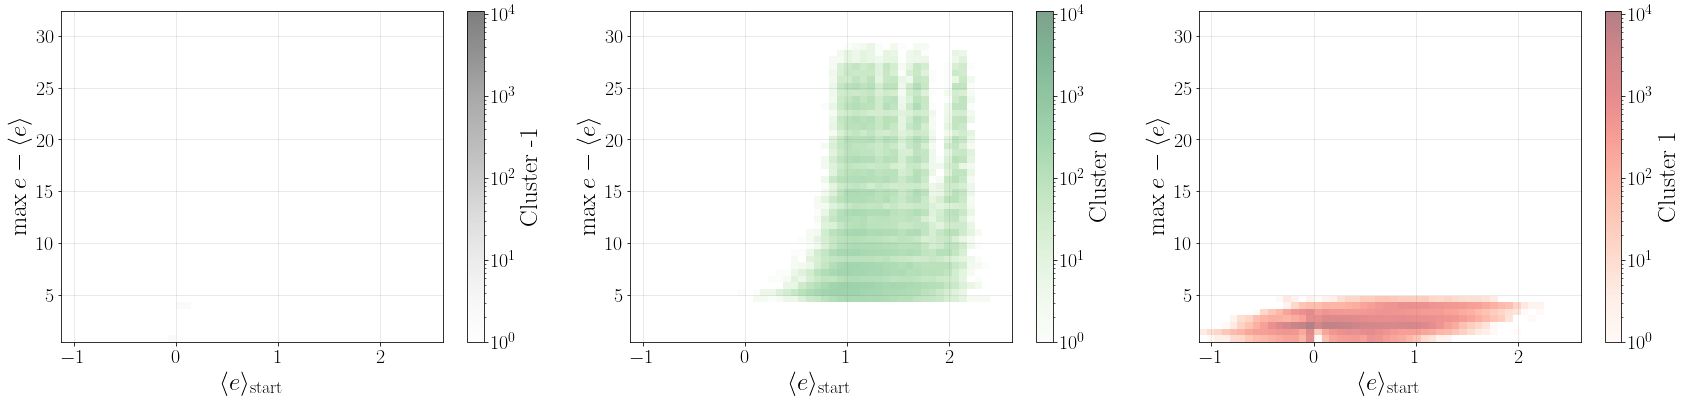

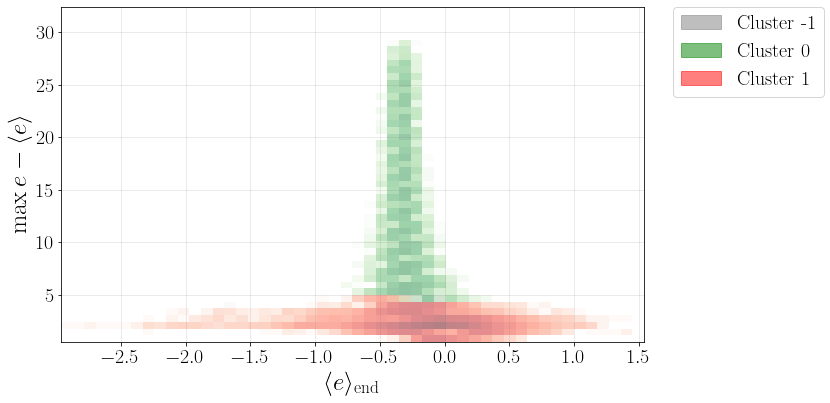

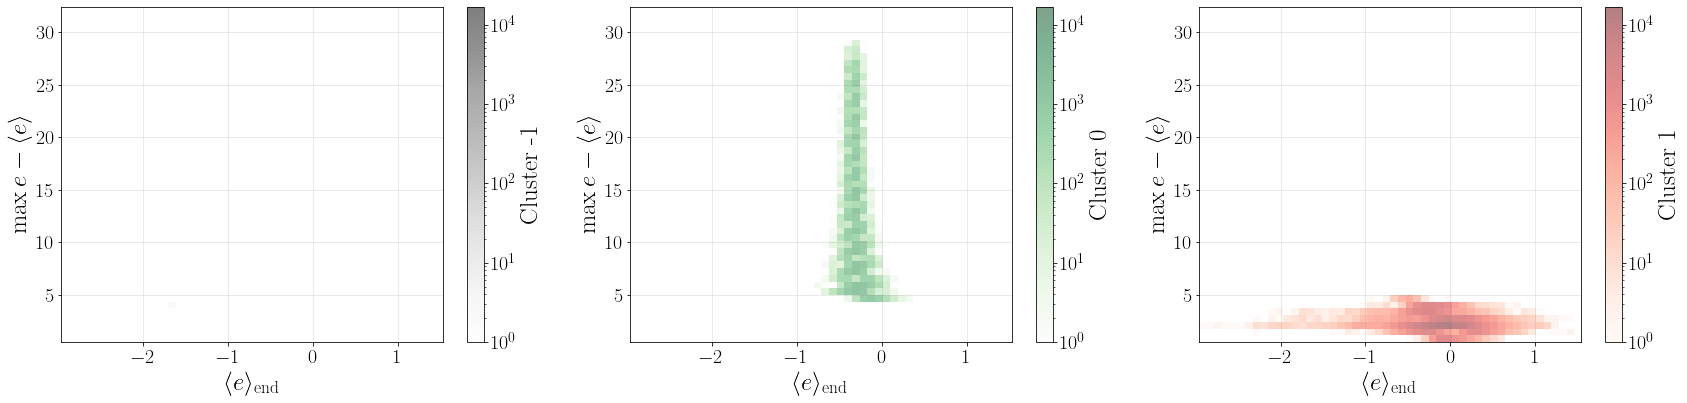

In [ ]:
dict_color_clu_labels = {
    -1: 'grey',
    0: 'g',
    1: 'r',
    2: 'g',
    3: 'orange',
    4: 'green', 
    5: "darkolivegreen"
}

clustering.plot_clusters_hist2d(
    dataframe_filtered, 
    features,
    column_labels,
    clu_label_name,
    logscale=True,
    dict_color_clu_cats=dict_color_clu_labels
)

In [ ]:
fcts.multi_plot_hist2d_cats(
    dataframe_filtered, 
    name_var1, name_var2,
    column_labels[name_var1], column_labels[name_var2],
    ["list_compos"],
)

In [ ]:
import matplotlib as mpl
mpl.colors.to_rgba('orange', alpha=0.1)

(1.0, 0.6470588235294118, 0.0, 0.1)

### DBscan

In [ ]:
from sklearn.cluster import OPTICS, DBSCAN

In [ ]:
clu_label_name = "OPTICS_SN"
clu_label_alias = "Signal vs Noise OPTICS"
clu_label_name = "DBSCAN_SN"
clu_label_alias = "Signal vs Noise DBSCAN"

In [ ]:
# features = ["mean_before_end_peak", "mean_after_end_peak"]
# cats = ["S", "N"]
# dbscan = DBSCAN(min_samples=10, eps=.1, algorithm='ball_tree', metric='haversine')
# dbscan = dbscan.fit(dataframe_filtered[features])
# dataframe_filtered[clu_label_name] = dbscan.labels_




features = ["mean_before_end_peak", "mean_after_end_peak"]
cats = ["S", "N"]
optics = OPTICS(min_samples=10, xi=0.1)
optics = optics.fit(dataframe_filtered[features])
dataframe_filtered[clu_label_name] = optics.labels_


KeyboardInterrupt: 

In [ ]:
np.unique(dataframe_filtered[clu_label_name])

array([  -1,    0,    1, ..., 1016, 1017, 1018])

(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='Signal vs Noise DBSCAN category', ylabel='Number of events'>)

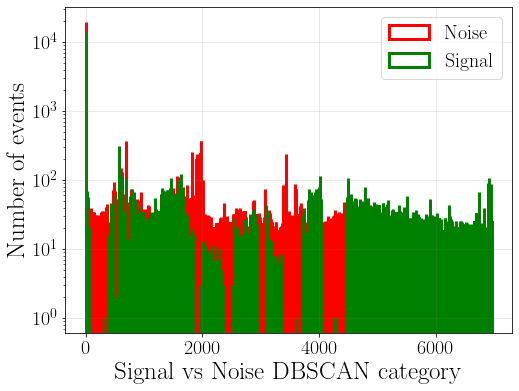

In [ ]:
fcts.plot_result_clustering(
    dataframe_filtered,
    clu_label_name,
    clu_label_alias,
    logscale=True,
    cats=cats[::-1]
)


(<Figure size 1152x432 with 2 Axes>,
 array([<AxesSubplot:xlabel='$\\langle e\\rangle_{\\text{start}}$', ylabel='Number of events'>,
        <AxesSubplot:xlabel='$\\langle e\\rangle_{\\text{end}}$', ylabel='Number of events'>],
       dtype=object))

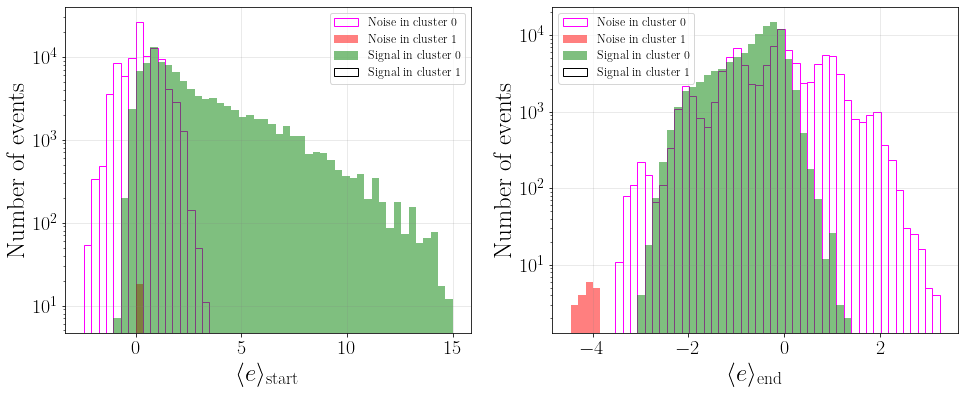

In [ ]:
# Correct cluster labels for each category ---------------------------

correct_clu_label_cats = {
    "S": 0,
    "N": 1,
}

fcts.plot_result_clustering_hist1d(
    dataframe_filtered.query(f"{clu_label_name}!=-1"), features,
    column_labels,
    clu_label_name, correct_clu_label_cats,
    logscale=True,
    cats=cats[::-1]
)

No events for Signal in cluster 1


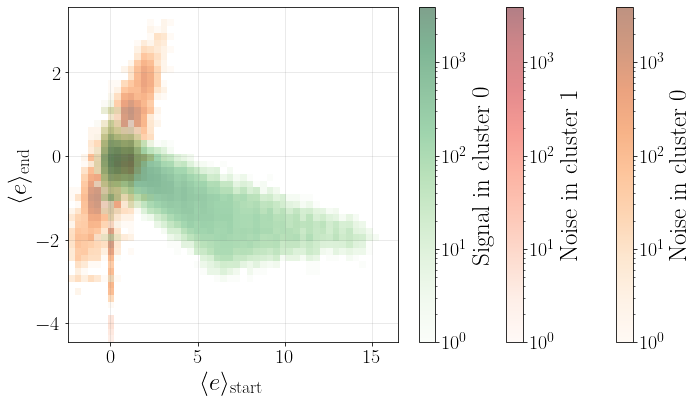

In [ ]:
fcts.plot_result_clustering_hist2d(
    dataframe_filtered.query(f"{clu_label_name}!=-1"), features,
    column_labels,
    clu_label_name, correct_clu_label_cats,
    logscale=True,
    cats=cats[::-1]
)

(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='Time increment', ylabel='Output'>)

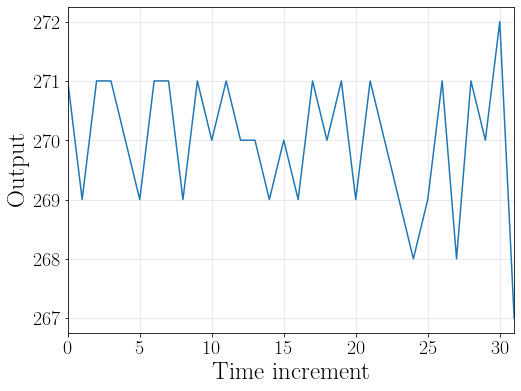

In [ ]:
lp.plot_event(dataframe_filtered.query("mean_after_end_peak<=-4").iloc[1])

#### Effect of imbalance: less signal than noise

In [ ]:
import pandas as pd 

dataframe_kmeans_less_signal = pd.concat(
    [
        dataframe_filtered.query('is_noise==True'),
        dataframe_filtered.query('is_sig==True').sample(frac=0.1)
    ]
)

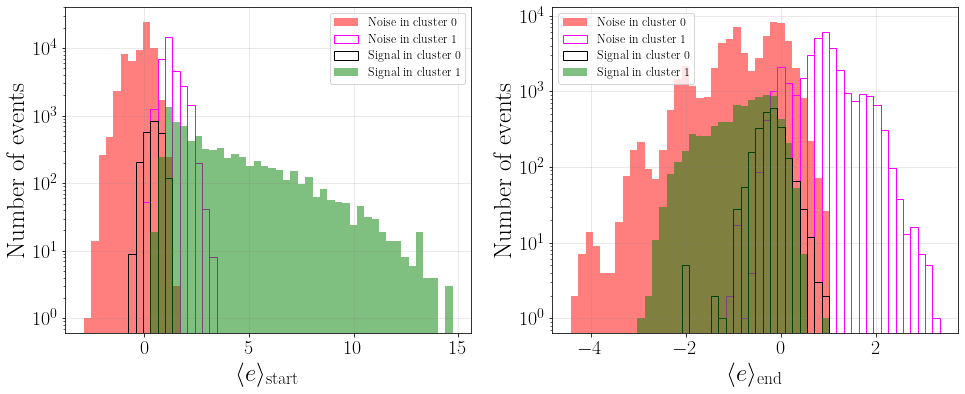

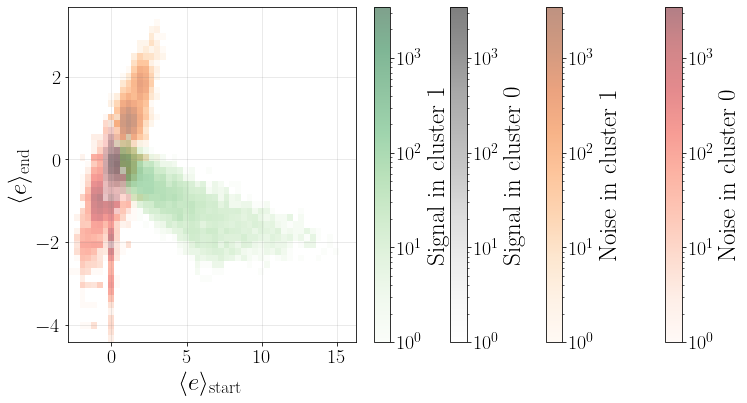

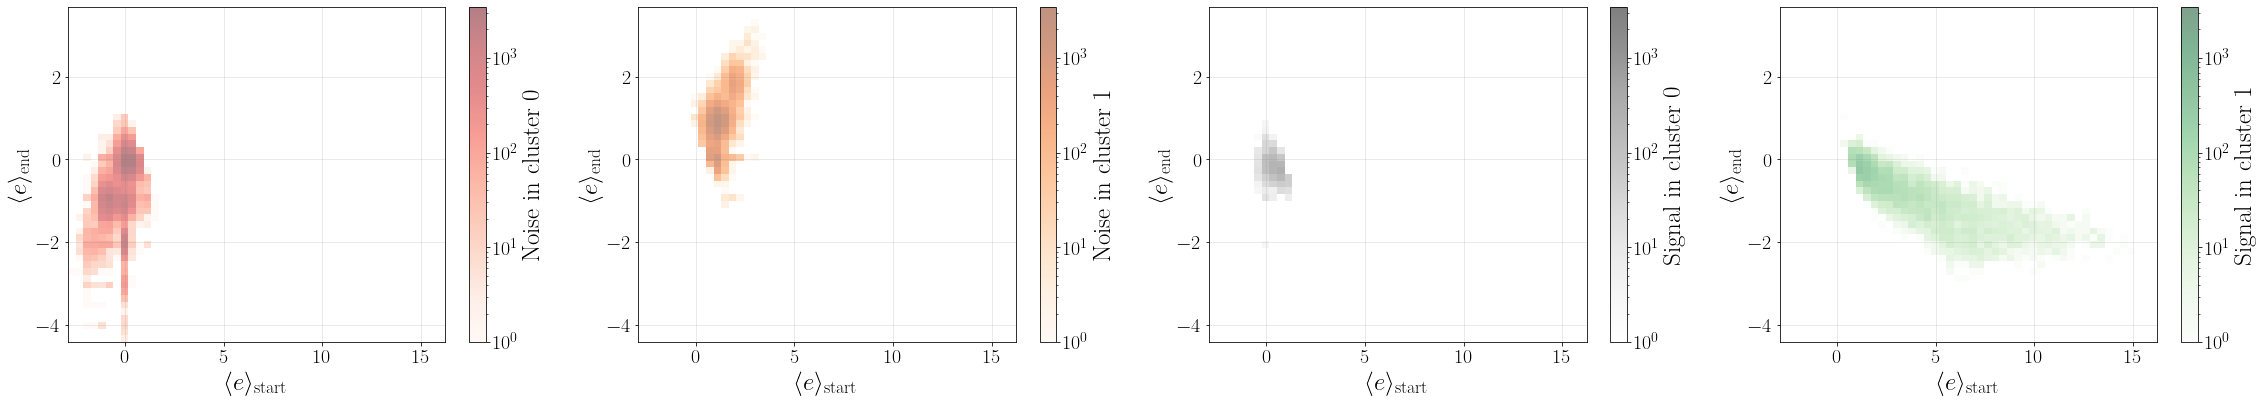

In [ ]:
features = ["mean_before_end_peak", "mean_after_end_peak"]
cats = ["S", "N"]
kmeans = KMeans(
    init="k-means++", #algorithm="elkan",
    n_clusters=2, random_state=rng.integers(2**32)
)
kmeans = kmeans.fit(dataframe_kmeans_less_signal[features])
dataframe_kmeans_less_signal[clu_label_name] = kmeans.labels_

fcts.plot_result_clustering(
    dataframe_kmeans_less_signal,
    clu_label_name,
    clu_label_alias,
    logscale=True,
    cats=cats[::-1]
)

# Correct cluster labels for each category ---------------------------

correct_clu_label_cats = {
    "S": 1,
    "N": 0,
}

fcts.plot_result_clustering_hist1d(
    dataframe_kmeans_less_signal, features,
    column_labels,
    clu_label_name, correct_clu_label_cats,
    logscale=True,
    cats=cats[::-1]
)
correct_clu_label_cats = {
    'S': 1,
    'N': 0,
}

fcts.plot_result_clustering_hist2d(
    dataframe_kmeans_less_signal, features,
    column_labels,
    clu_label_name, correct_clu_label_cats,
    logscale=True,
    cats=cats[::-1]
)